# Process Data

In this notebook we are processing data loaded in Bronze layer and utilize Bigquery AI/ML functions.

### Setting-up Environment

In [1]:
import os

PROJECT_ID = "market-mirror-dev"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
BUCKET_NAME = "marke-mirror-dev-data"  # @param {type: "string", placeholder: "[your-bucket-name]", isTemplate: true}
LOCATION = "US"  # @param {type: "string", placeholder: "[your-region]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

if not LOCATION or LOCATION == "[your-region]":
    LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "US")


In [2]:
os.environ['GOOGLE_CLOUD_PROJECT'] = PROJECT_ID
os.environ['GOOGLE_CLOUD_REGION'] = LOCATION

In [3]:
BQ_BRONZE_DATASET = "APP_MARKET_BRONZE" # @param {type: "string", placeholder: "[bronze-dataset]", isTemplate: true}
BQ_SILVER_DATASET = "APP_MARKET_SILVER" # @param {type: "string", placeholder: "[silver-dataset]", isTemplate: true}
BQ_GOLD_DATASET = "APP_MARKET_GOLD" # @param {type: "string", placeholder: "[gold-dataset]", isTemplate: true}

### Objective

#### Data Definitions



**We have loaded 6 Tables in BQ as Follows:**

**Review Tables:**

1. `{PROJECT_ID}.{BQ_BRONZE_DATASET}.multilingual_mobile_app_reviews_2025`

    * This table contains user reviews of various Apps from different platforms. like Android, iOS, Windows apps. Also it contains reviewed user information like Age, Country, Gender.

    * No. of columns : 15
    * No. of Records : 2514


**Product Information Tables:**

2. `{PROJECT_ID}.{BQ_BRONZE_DATASET}.cleanapp`

    * This table having all app related information from GooglePlaystore. Information include category, genre, app ratings, number of reviews, number of downloads etc.

    * No. Of Columns : 29
    * No. of Records : 11593

3. `{PROJECT_ID}.{BQ_BRONZE_DATASET}.AppleStore`

    * This table having all app related information from Apple Store. Information include category, genre, app ratings, size, price etc.

    * No. Of Columns : 17
    * No. of Records : 7197

4. `{PROJECT_ID}.{BQ_BRONZE_DATASET}.appleStore_description`

    * This table having elaborated description in various languages about the Apps available in Apple Store.

    * No. Of Columns : 5
    * No. of Records : 7197

5. `{PROJECT_ID}.{BQ_BRONZE_DATASET}.windows_store`

    * This table having elaborated description about the Apps available in Windows Store.

    * No. Of Columns : 9
    * No. of Records : 3960





#### Data Engineering

**Review Tables**


*   In the `multilingual_mobile_app_reviews_2025` table, we can see that `application_category` is mapped incorrectly to many apps. Same app is being mapped to irrelavant categories. We are going to update the correct category using **BigQuery AI/ML** Functions.

*   Also, in the same `multilingual_mobile_app_reviews_2025` table, we can see reviews are in various languages. So we  are going to convert them to English using **BigQuery AI/ML** Functions.

* Clean-up and use GenAI to improve the features.

* Load the necessary column only to Silver Layer.


**Product Information Tables**

* Combine the `AppleStore` and `appleStore_description` tables into a single table.

* We can see the `appleStore_description` is having various languages. Convert them into a single language.

* Generate Embeddings for the App description columns to enable vector search.

* Create the `cleannapp` and `windows_store` as separate tables with necessary columns.

#### Creating Vertex AI Remote Models

In [4]:
!bq mk --connection --location=$GOOGLE_CLOUD_REGION --project_id=$GOOGLE_CLOUD_PROJECT \
    --connection_type=CLOUD_RESOURCE vertex-remote-models

BigQuery error in mk operation: Already Exists: Connection
projects/468982775008/locations/us/connections/vertex-remote-models


In [5]:
create_embed_model = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{BQ_SILVER_DATASET}.embeddings`
REMOTE WITH CONNECTION `us.vertex-remote-models`
OPTIONS (ENDPOINT = 'text-embedding-005');
"""

create_gen_model = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{BQ_SILVER_DATASET}.gemini`
REMOTE WITH CONNECTION `us.vertex-remote-models`
OPTIONS (ENDPOINT = 'gemini-2.0-flash');
"""


In [6]:
# @title Error Handling Tip

'''
If you get error while running below cells to create Remote models related to
Service account privilge, run the below command, after replacing the
`SERVICE_ACCOUNT_EMAIL` with the service account shown in the error.
'''
!gcloud projects add-iam-policy-binding $GOOGLE_CLOUD_PROJECT \
    --member="serviceAccount:SERVICE_ACCOUNT_EMAIL" \
    --role="roles/aiplatform.user"


ERROR: Policy modification failed. For a binding with condition, run "gcloud alpha iam policies lint-condition" to identify issues in condition.
ERROR: (gcloud.projects.add-iam-policy-binding) INVALID_ARGUMENT: Invalid service account (SERVICE_ACCOUNT_EMAIL).


In [7]:
%%bigquery
$create_embed_model

Query is running:   0%|          |

""


In [8]:
%%bigquery
$create_gen_model

Query is running:   0%|          |

""


#### Review Table Data Processing

In [9]:
import bigframes.pandas as bpd
import bigframes.bigquery as bbq
from bigframes.ml import llm

# Set BigQuery DataFrames options
# Note: The project option is not required in all environments.
# On BigQuery Studio, the project ID is automatically detected.
bpd.options.bigquery.project = PROJECT_ID

# Note: The location option is not required.
# It defaults to the location of the first table or query
# passed to read_gbq(). For APIs where a location can't be
# auto-detected, the location defaults to the "US" location.
bpd.options.bigquery.location = LOCATION

##### Exploring Data

In [10]:
review_df = bpd.read_gbq(f'{PROJECT_ID}.{BQ_BRONZE_DATASET}.multilingual_mobile_app_reviews_2025')

In [11]:
review_df.head()

,review_id,user_id,app_name,app_category,review_text,review_language,rating,review_date,verified_purchase,device_type,num_helpful_votes,user_age,user_country,user_gender,app_version
0,470,2402031,Google Maps,Social Networking,Cum veritatis minima. Cumque consectetur quos ...,hi,4.7,2024-02-21 02:48:54+00:00,False,Android,728,75.0,France,Female,6.9.13-beta
1,82,9758155,Udemy,News & Magazines,This app is amazing! Really love the new featu...,th,2.4,2023-12-29 21:36:49+00:00,False,Windows Phone,853,24.0,Thailand,Male,1.8
2,1280,5696685,eBay,Productivity,This app is amazing! Really love the new featu...,hi,1.8,2024-09-07 12:31:24+00:00,True,iOS,1028,40.0,Japan,Non-binary,6.4.22
3,1981,3633909,LinkedIn,Entertainment,Possimus perferendis ducimus adipisci sequi vo...,ja,2.7,2024-03-08 09:07:42+00:00,True,iOS,703,70.0,India,Female,2.4.48
4,1525,1725497,WhatsApp,Social Networking,Placeat quo consectetur.,ar,4.9,2024-05-06 22:33:59+00:00,False,Windows Phone,1080,60.0,Russia,Prefer not to say,11.1


In [12]:
review_df.columns

Index(['review_id', 'user_id', 'app_name', 'app_category', 'review_text',
       'review_language', 'rating', 'review_date', 'verified_purchase',
       'device_type', 'num_helpful_votes', 'user_age', 'user_country',
       'user_gender', 'app_version'],
      dtype='object')

In [13]:
#lets keep only necessary column
#ignoring the review language column since its looks like not relavent. Even reviews in English is having different language code.

review_df_subset = review_df[['review_id', 'app_name','app_category','review_text','rating','review_date','user_age','user_country',
                       'user_gender']]

In [14]:
review_df_subset.head(5)

,review_id,app_name,app_category,review_text,rating,review_date,user_age,user_country,user_gender
0,470,Google Maps,Social Networking,Cum veritatis minima. Cumque consectetur quos ...,4.7,2024-02-21 02:48:54+00:00,75.0,France,Female
1,82,Udemy,News & Magazines,This app is amazing! Really love the new featu...,2.4,2023-12-29 21:36:49+00:00,24.0,Thailand,Male
2,1280,eBay,Productivity,This app is amazing! Really love the new featu...,1.8,2024-09-07 12:31:24+00:00,40.0,Japan,Non-binary
3,1981,LinkedIn,Entertainment,Possimus perferendis ducimus adipisci sequi vo...,2.7,2024-03-08 09:07:42+00:00,70.0,India,Female
4,1525,WhatsApp,Social Networking,Placeat quo consectetur.,4.9,2024-05-06 22:33:59+00:00,60.0,Russia,Prefer not to say


In [15]:
review_df_subset.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 2514 entries, 0 to 2513
Data columns (total 9 columns):
  #  Column        Non-Null Count    Dtype
---  ------------  ----------------  ------------------------------
  0  review_id     2514 non-null     Int64
  1  app_name      2514 non-null     string
  2  app_category  2514 non-null     string
  3  review_text   2455 non-null     string
  4  rating        2477 non-null     Float64
  5  review_date   2514 non-null     timestamp[us, tz=UTC][pyarrow]
  6  user_age      2514 non-null     Float64
  7  user_country  2473 non-null     string
  8  user_gender   1927 non-null     string
dtypes: Float64(2), Int64(1), string(5), timestamp[us, tz=UTC][pyarrow](1)
memory usage: 201120 bytes


##### Data Cleaning steps



* NULL Validation

  1. review_text - without review no use of the records. Remove them.
  2. rating      - take average rating and populate them.
  3. user_country - update with most probable country.
  4. user_gender - its ok to have nulls or update.

* Data Validation

  1. review_id
    *   This column should not have duplicates. If so, generate our id.
  2. app_name
    *   Check if data is consistant
    *   Same app should not be having multiple names with incorrect spelling/space etc.
  3. app_category
    * Check if each app associated with a single app category. If not fix the same with the use of `GenAI`
    * App category values should  be consistant. Should not be having similar name with spelling  mistakes etc.
  4. review_text
    * Add another feature column review_language with the help of `GenAI` to identify in which language review is written.
  5. user_age
    * Check if the values are consistant. Values should be between acceptable human age.
  6. user_country
    * Check if the values are consistant.
    * Same country should not be having multiple values with incorrect spelling.
  7. user_gender
    * Check if the values are consistant.
    * Same gender should not be having multiple values with incorrect spelling.


##### Fixing NULL values

In [16]:
review_df_subset.isna().sum()

review_df_subset = review_df_subset.dropna(subset=['review_text'])

In [17]:
review_df_subset.isna().sum()

review_id         0
app_name          0
app_category      0
review_text       0
rating           37
review_date       0
user_age          0
user_country     41
user_gender     578
dtype: Int64

In [18]:
app_with_rating_na = review_df_subset[review_df_subset['rating'].isna()]['app_name'].drop_duplicates().to_list()
app_mean_rating = review_df_subset[review_df_subset['app_name'].isin(app_with_rating_na)][['app_name','rating']].groupby('app_name').mean()
app_mean_rating = app_mean_rating.reset_index()
app_mean_rating = app_mean_rating.rename(columns={'rating':'rating_mean'})
review_df_subset = bpd.merge(review_df_subset, app_mean_rating, on='app_name', how='left')
review_df_subset['rating'] = review_df_subset['rating'].fillna(review_df_subset.rating_mean.round(2))
review_df_subset = review_df_subset.drop(columns=['rating_mean'])


In [19]:
review_df_subset.isna().sum()

review_id         0
app_name          0
app_category      0
review_text       0
rating            0
review_date       0
user_age          0
user_country     41
user_gender     578
dtype: Int64

In [69]:
country_nulls = review_df_subset[review_df_subset.user_country.isna()].app_name.drop_duplicates().to_list()

In [70]:
null_country_df = review_df_subset[review_df_subset.app_name.isin(country_nulls)][['app_name','user_country']]
app_tot_count_df = null_country_df.groupby('app_name').count().reset_index().rename(columns={'user_country':'tot_count'})
# group by app_name and user_country to get count for each app how many times a particular county comes
null_country_df = null_country_df.groupby(['app_name','user_country']).size().reset_index(name='count')
null_country_df = bpd.merge(null_country_df, app_tot_count_df, on='app_name', how='left')
null_country_df['country_rank'] = (null_country_df['count']/null_country_df['tot_count'])*100

null_country_df['rank'] = null_country_df.groupby(['app_name'])['country_rank'].rank(method='first',ascending=False)
null_country_df = null_country_df.sort_values(by=['app_name','rank'], ascending=[True,True])
null_country_df = null_country_df.rename(columns={'rank':'country_rank_final'})
null_country_df = null_country_df[null_country_df.country_rank_final==1].drop(columns=['count','tot_count','country_rank','country_rank_final'])

null_country_df = null_country_df.rename(columns={'user_country':'user_country_final'})
review_df_subset = bpd.merge(review_df_subset, null_country_df, on='app_name', how='left')
review_df_subset['user_country'] = review_df_subset['user_country'].fillna(review_df_subset.user_country_final)
review_df_subset = review_df_subset.drop(columns=['user_country_final'])



In [72]:
review_df_subset.isna().sum()

review_id         0
app_name          0
app_category      0
review_text       0
rating            0
review_date       0
user_age          0
user_country      0
user_gender     578
dtype: Int64

In [76]:
review_df_subset['user_gender'].value_counts()

user_gender
Female               483
Non-binary           473
Male                 468
Prefer not to say    453
Name: count, dtype: Int64

In [74]:
gender_nulls = review_df_subset[review_df_subset.user_gender.isna()].app_name.drop_duplicates().to_list()

In [77]:
null_gender_df = review_df_subset[review_df_subset.app_name.isin(gender_nulls)][['app_name','user_gender']]
app_tot_count_df = null_gender_df.groupby('app_name').count().reset_index().rename(columns={'user_gender':'tot_count'})
# group by app_name and user_gender to get count for each app how many times a particular county comes
null_gender_df = null_gender_df.groupby(['app_name','user_gender']).size().reset_index(name='count')
null_gender_df = bpd.merge(null_gender_df, app_tot_count_df, on='app_name', how='left')
null_gender_df['gender_rank'] = (null_gender_df['count']/null_gender_df['tot_count'])*100

null_gender_df['rank'] = null_gender_df.groupby(['app_name'])['gender_rank'].rank(method='first',ascending=False)
null_gender_df = null_gender_df.sort_values(by=['app_name','rank'], ascending=[True,True])
null_gender_df = null_gender_df.rename(columns={'rank':'gender_rank_final'})
null_gender_df = null_gender_df[null_gender_df.gender_rank_final==1].drop(columns=['count','tot_count','gender_rank','gender_rank_final'])

null_gender_df = null_gender_df.rename(columns={'user_gender':'user_gender_final'})
review_df_subset = bpd.merge(review_df_subset, null_gender_df, on='app_name', how='left')
review_df_subset['user_gender'] = review_df_subset['user_gender'].fillna(review_df_subset.user_gender_final)
review_df_subset = review_df_subset.drop(columns=['user_gender_final'])


In [79]:
review_df_subset.isna().sum()

review_id       0
app_name        0
app_category    0
review_text     0
rating          0
review_date     0
user_age        0
user_country    0
user_gender     0
dtype: Int64

In [83]:
#Write data to BQ
review_df_subset.to_gbq(destination_table=f'{PROJECT_ID}.{BQ_SILVER_DATASET}.T_APP_REVIEWS',if_exists='replace')

'market-mirror-dev.APP_MARKET_SILVER.T_APP_REVIEWS'

##### Fixing Inconsistant Data

In [84]:
app_reviews_df = bpd.read_gbq(f'{PROJECT_ID}.{BQ_SILVER_DATASET}.T_APP_REVIEWS')

In [86]:
#Checking review_id having unique values.
app_reviews_df.review_id.nunique() # same as the total count so, review_id having unique values

np.int64(2455)

In [95]:
#Checking app_name column having consistent values
app_reviews_df.app_name.value_counts()

app_name
Pinterest           78
Reddit              78
Google Drive        74
OneDrive            74
Instagram           71
Dropbox             67
MX Player           67
Microsoft Office    67
Telegram            67
Grammarly           66
Adobe Photoshop     64
Uber                64
Waze                64
YouTube             64
Airbnb              63
Booking.com         62
TikTok              62
Tinder              62
Netflix             61
Google Maps         59
PayPal              59
Zoom                59
Coursera            57
Duolingo            57
Canva               56
Name: count, dtype: Int64

<Axes: ylabel='Frequency'>

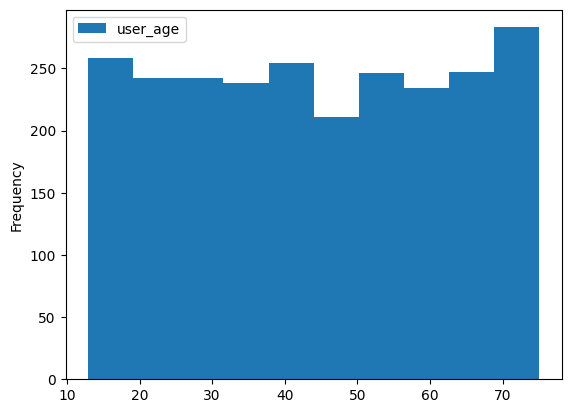

In [94]:
#Checking user_age column having consistent values
app_reviews_df.user_age.plot.hist()

In [96]:
#Checking user_country column having consistent values
app_reviews_df.user_country.value_counts()

user_country
Australia         136
Germany           119
Indonesia         117
Turkey            113
Italy             109
Malaysia          109
India             107
United Kingdom    107
Japan             105
Mexico            105
Vietnam           105
Nigeria           103
Brazil            100
Spain              99
China              97
Russia             96
Bangladesh         95
Pakistan           94
South Korea        93
France             92
Thailand           90
United States      89
Philippines        88
Canada             87
Name: count, dtype: Int64

In [97]:
#Checking user_gender column having consistent values
app_reviews_df.user_gender.value_counts()

user_gender
Female               648
Prefer not to say    631
Non-binary           589
Male                 587
Name: count, dtype: Int64

In [100]:
# same app mapped to multiple incorrect app_categories
unique_app_cat_df = app_reviews_df[['app_name','app_category']].drop_duplicates().sort_values(by='app_name')

In [110]:
unique_app_cat_df = bbq.array_agg(unique_app_cat_df.groupby('app_name')).reset_index()

In [113]:
unique_app_cat_df.head()

,app_name,app_category
0,Adobe Photoshop,['Music & Audio' 'Utilities' 'Social Networkin...
1,Airbnb,['Business' 'Photography' 'Navigation' 'Utilit...
2,Amazon,['Business' 'Communication' 'Productivity' 'Da...
3,Booking.com,['Health & Fitness' 'Music & Audio' 'Games' 'S...
4,Bumble,['Entertainment' 'Utilities' 'Music & Audio' '...


In [138]:
unique_app_cat_df['app_category_str'] = bbq.array_to_string(unique_app_cat_df.app_category,',')
unique_app_cat_df = unique_app_cat_df.drop(columns='app_category')


In [158]:
unique_app_cat_df.head()

,app_name,app_category_str,prompt
0,Adobe Photoshop,"Music & Audio,Utilities,Social Networking,Comm...",I have app_name and app_category columns. ...
1,Airbnb,"Business,Photography,Navigation,Utilities,Heal...",I have app_name and app_category columns. ...
2,Amazon,"Business,Communication,Productivity,Dating,Sho...",I have app_name and app_category columns. ...
3,Booking.com,"Health & Fitness,Music & Audio,Games,Social Ne...",I have app_name and app_category columns. ...
4,Bumble,"Entertainment,Utilities,Music & Audio,Dating,V...",I have app_name and app_category columns. ...


In [115]:
model = llm.GeminiTextGenerator(model_name='gemini-2.0-flash',connection_name='us.vertex-remote-models')

/usr/local/lib/python3.11/dist-packages/bigframes/ml/llm.py:508: UserWarning: Model name 'gemini-2.0-flash' is not supported. We are currently aware
of the following models: gemini-1.5-pro-preview-0514,
gemini-1.5-flash-preview-0514, gemini-1.5-pro-001, gemini-1.5-pro-002,
gemini-1.5-flash-001, gemini-1.5-flash-002, gemini-2.0-flash-exp,
gemini-2.0-flash-001, gemini-2.0-flash-lite-001. However, model names
can change, and the supported models may be outdated. You should use
this model name only if you are sure that it is supported in BigQuery.
  warnings.warn(msg)


In [141]:
unique_app_cat_df['prompt'] = 'I have app_name and app_category columns. \
              In the app_category column can you choose the correct category suitable for the app based? \
              answer with only the correct app_category. app_name : ' + unique_app_cat_df.app_name + ' app_category list : '+ unique_app_cat_df.app_category_str

In [149]:
df = model.predict(X=unique_app_cat_df
              ,temperature=0.1
              )

/usr/local/lib/python3.11/dist-packages/bigframes/core/array_value.py:108: PreviewWarning: JSON column interpretation as a custom PyArrow extention in
`db_dtypes` is a preview feature and subject to change.
  warnings.warn(msg, bfe.PreviewWarning)


In [151]:
llm_response_df = df[['app_name','ml_generate_text_llm_result']]

In [152]:
llm_response_df = llm_response_df.rename(columns={'ml_generate_text_llm_result':'correct_app_category'})

In [153]:
app_reviews_df = bpd.merge(app_reviews_df, llm_response_df, on='app_name', how='left')
app_reviews_df['app_category'] = app_reviews_df['correct_app_category']
app_reviews_df = app_reviews_df.drop(columns=['correct_app_category'])

In [159]:
app_reviews_df.to_gbq(destination_table=f'{PROJECT_ID}.{BQ_SILVER_DATASET}.T_APP_REVIEWS',if_exists='replace')

'market-mirror-dev.APP_MARKET_SILVER.T_APP_REVIEWS'

In [164]:
translation_df = app_reviews_df[['review_id','review_text']]

In [175]:
translation_df['prompt'] = '''can you identify what language the given text is written in and give English translation of the same?
if the given text is already in english you just give language output. No need to provide traslation.
Text : ''' + translation_df.review_text

In [166]:
translation_df[0:10]

,review_id,review_text,prompt
0,1091,Sonne oder Herr. Gott halten Haare rot Finger ...,can you identify what language the given text ...
1,1978,"Great app but too many ads, consider premium v...",can you identify what language the given text ...
2,876,Excellent customer support and regular feature...,can you identify what language the given text ...
3,766,"Great app but too many ads, consider premium v...",can you identify what language the given text ...
4,361,再現する電池ピックニュース月。 差別するトーンブラケット仕上げ必要。,can you identify what language the given text ...
5,1348,"Perfect for daily use, highly recommend to eve...",can you identify what language the given text ...
6,1855,This app is amazing! Really love the new featu...,can you identify what language the given text ...
7,2238,Deleniti sed quidem dolorem. Odio nihil nobis ...,can you identify what language the given text ...
8,1741,"Crashes too often, needs improvement in stabil...",can you identify what language the given text ...
9,214,The interface could be better but overall good...,can you identify what language the given text ...


In [171]:
{'language':{'type':'STRING'},
  'translated_review':{'type':'STRING'}}

{'language': {'type': 'STRING'}, 'translated_review': {'type': 'STRING'}}

In [178]:
llm_output = model.predict(X=translation_df
              ,temperature=0.1
              ,output_schema={'language':'STRING','translated_review':'STRING'}
              )

/usr/local/lib/python3.11/dist-packages/bigframes/core/array_value.py:108: PreviewWarning: JSON column interpretation as a custom PyArrow extention in
`db_dtypes` is a preview feature and subject to change.
  warnings.warn(msg, bfe.PreviewWarning)


In [180]:
english_translated_review_df = llm_output[['review_id','language','translated_review']]

In [181]:
app_reviews_df = bpd.merge(app_reviews_df, english_translated_review_df, on='review_id', how='left')

In [183]:
app_reviews_df['translated_review'] = app_reviews_df['translated_review'].fillna(app_reviews_df.review_text)

In [184]:
app_reviews_df.to_gbq(destination_table=f'{PROJECT_ID}.{BQ_SILVER_DATASET}.T_APP_REVIEWS',if_exists='replace')

'market-mirror-dev.APP_MARKET_SILVER.T_APP_REVIEWS'